# 당뇨와 고혈압 질병 예측
- BTH_G : 연령(그룹)
- SBP : 수축기혈압
- DBP : 이완기혈압
- FBS : 공복혈당
- SEX : 성별(남성:1, 여성:2)
- DIS : 고혈압/당뇨병 진료여부
  - 고혈압/당뇨병 진료내역 있음: 1
  - 고혈압 진료내역 있음: 2
  - 당뇨병 진료내역 있음: 3
  - 고혈압/당뇨병 진료내역 없음: 4
- BMI : 체질량지수

## 정상 vs 비정상
- 4(정상) : 0
- 1 / 2 / 3(비정상) : 1

- 0(정상) 기준으로 1(비정상) 오버샘플링 : RandomOversampling
- 1(비정상) : 1 / 2 / 3 각각 레이블링 됨

1 / 2 / 3 = 비율) 1 : 3 : 1
=> 1 : 1 : 1 비율로 오버샘플링

1 / 0 = 비율) 1 : 3
=> 1 : 1 비율로 오버샘플링

# LightGBM
+
## RandomOversampling + 질병 1, 2, 3 비율 => 1 : 1 : 1

### LightGBM 설치:

```
pip3 install lightgbm

```



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd # 시리즈, 데이터프레임 포맷 데이터 처리를 위한 라이브러리
import warnings; warnings.filterwarnings(action='ignore') # 경고 메시지 무시
import matplotlib.pyplot as plt # 데이터 시각화 라이브러리
import pickle # 객체 입출력을 위한 라이브러리

from sklearn.model_selection import train_test_split # 훈련 데이터, 테스트 데이터 분리
from sklearn.preprocessing import StandardScaler # 정규화

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score


# LightGBM 임포트
from lightgbm import LGBMClassifier # LightGBM 불러오기

from pandas.core.common import random_state
from sklearn.ensemble import RandomForestClassifier # 랜덤포레스트 분류 알고리즘
from sklearn.tree import DecisionTreeClassifier # 의사결정나무 분류 알고리즘

import matplotlib.pyplot as plt
import seaborn as sns

# 모델 평가를 위한 metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## 데이터 불러오기

In [ ]:
# Disease 

df = pd.read_csv('/content/drive/MyDrive/health/data/data(over_dis_vs_nor).csv', encoding='cp949')
df

,SEX,BTH_G,SBP,DBP,FBS,BMI,DIS,Dis
0,0,1,90,50,86,20.1,2,1
1,0,1,120,80,90,27.0,3,1
2,0,1,100,60,112,31.8,2,1
3,0,1,170,120,86,23.3,2,1
4,0,1,135,80,104,35.0,2,1
...,...,...,...,...,...,...,...,...
1481319,1,21,130,90,185,26.3,3,1
1481320,1,18,140,100,120,28.8,2,1
1481321,0,12,100,60,101,23.0,3,1
1481322,1,20,134,72,168,23.1,3,1


In [ ]:
df.drop(df[df['Dis']==0].index, inplace=True)
df

,SEX,BTH_G,SBP,DBP,FBS,BMI,DIS,Dis
0,0,1,90,50,86,20.1,2,1
1,0,1,120,80,90,27.0,3,1
2,0,1,100,60,112,31.8,2,1
3,0,1,170,120,86,23.3,2,1
4,0,1,135,80,104,35.0,2,1
...,...,...,...,...,...,...,...,...
1481319,1,21,130,90,185,26.3,3,1
1481320,1,18,140,100,120,28.8,2,1
1481321,0,12,100,60,101,23.0,3,1
1481322,1,20,134,72,168,23.1,3,1


In [ ]:
# 1,0 정답 레이블 삭제
df.drop(['Dis'], axis=1, inplace=True)
df

,SEX,BTH_G,SBP,DBP,FBS,BMI,DIS
0,0,1,90,50,86,20.1,2
1,0,1,120,80,90,27.0,3
2,0,1,100,60,112,31.8,2
3,0,1,170,120,86,23.3,2
4,0,1,135,80,104,35.0,2
...,...,...,...,...,...,...,...
1481319,1,21,130,90,185,26.3,3
1481320,1,18,140,100,120,28.8,2
1481321,0,12,100,60,101,23.0,3
1481322,1,20,134,72,168,23.1,3


In [ ]:
df.reset_index()

,index,SEX,BTH_G,SBP,DBP,FBS,BMI,DIS
0,0,0,1,90,50,86,20.1,2
1,1,0,1,120,80,90,27.0,3
2,2,0,1,100,60,112,31.8,2
3,3,0,1,170,120,86,23.3,2
4,4,0,1,135,80,104,35.0,2
...,...,...,...,...,...,...,...,...
740657,1481319,1,21,130,90,185,26.3,3
740658,1481320,1,18,140,100,120,28.8,2
740659,1481321,0,12,100,60,101,23.0,3
740660,1481322,1,20,134,72,168,23.1,3


In [ ]:
df.reset_index(drop=True)

,SEX,BTH_G,SBP,DBP,FBS,BMI,DIS
0,0,1,90,50,86,20.1,2
1,0,1,120,80,90,27.0,3
2,0,1,100,60,112,31.8,2
3,0,1,170,120,86,23.3,2
4,0,1,135,80,104,35.0,2
...,...,...,...,...,...,...,...
740657,1,21,130,90,185,26.3,3
740658,1,18,140,100,120,28.8,2
740659,0,12,100,60,101,23.0,3
740660,1,20,134,72,168,23.1,3


In [ ]:
df.sample(frac=1.0, replace=False, weights=None, random_state=None, axis=None, ignore_index=False)

,SEX,BTH_G,SBP,DBP,FBS,BMI,DIS
294593,1,19,119,65,92,20.5,1
1439529,0,8,126,78,91,26.6,2
1312380,1,27,124,64,124,19.1,1
1329521,0,18,94,63,99,20.4,3
1924,0,6,140,90,101,33.2,2
...,...,...,...,...,...,...,...
1338335,0,17,122,72,209,22.7,3
78973,0,20,140,90,125,27.3,2
291431,1,19,139,89,175,28.9,1
1254407,0,12,119,65,210,18.9,3


In [ ]:
df.reset_index()

,index,SEX,BTH_G,SBP,DBP,FBS,BMI,DIS
0,0,0,1,90,50,86,20.1,2
1,1,0,1,120,80,90,27.0,3
2,2,0,1,100,60,112,31.8,2
3,3,0,1,170,120,86,23.3,2
4,4,0,1,135,80,104,35.0,2
...,...,...,...,...,...,...,...,...
740657,1481319,1,21,130,90,185,26.3,3
740658,1481320,1,18,140,100,120,28.8,2
740659,1481321,0,12,100,60,101,23.0,3
740660,1481322,1,20,134,72,168,23.1,3


In [ ]:
df.reset_index(drop=True)

,SEX,BTH_G,SBP,DBP,FBS,BMI,DIS
0,0,1,90,50,86,20.1,2
1,0,1,120,80,90,27.0,3
2,0,1,100,60,112,31.8,2
3,0,1,170,120,86,23.3,2
4,0,1,135,80,104,35.0,2
...,...,...,...,...,...,...,...
740657,1,21,130,90,185,26.3,3
740658,1,18,140,100,120,28.8,2
740659,0,12,100,60,101,23.0,3
740660,1,20,134,72,168,23.1,3


In [ ]:
df.notnull().sum()

SEX      740662
BTH_G    740662
SBP      740662
DBP      740662
FBS      740662
BMI      740662
DIS      740662
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 740662 entries, 0 to 1481323
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   SEX     740662 non-null  int64  
 1   BTH_G   740662 non-null  int64  
 2   SBP     740662 non-null  int64  
 3   DBP     740662 non-null  int64  
 4   FBS     740662 non-null  int64  
 5   BMI     740662 non-null  float64
 6   DIS     740662 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 45.2 MB


In [ ]:
# feature와 target 분리(설명변수 및 목표변수 분리)
x = df.drop(['DIS'], axis=1) # df[df.columns.difference(['target'])]
y = np.array(df['DIS']) # y = df['target']

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x)
x_test = sc.transform(x)

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2, random_state=42) # 기본 0.25
# x_test,x_val,y_test,y_val=train_test_split(x,y,test_size=0.1, random_state=42)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
# print(x_val.shape)
# print(y_val.shape)

(592529, 6)
(592529,)
(148133, 6)
(148133,)


### lightgbm 파라미터 정의

In [ ]:
hyper_params = {
    'num_iterations': 3500,
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_error', # ['auc_mu', 'multi_logloss', 
    'learning_rate': 0.1, # 0.005
    'feature_fraction': 1.0, # 0.9
    'bagging_fraction': 1.0, # 0.7
    'bagging_freq': 10,
    'verbose': 0,
    'max_depth': 8, # 20
    # 'min_data' : 20
    # 'min_child_samples' =60
    'num_leaves': 128, # 31
    'max_bin': 512, # 255
    # 'device' : 'gpu'
}

### 훈련

In [ ]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(**hyper_params)
evals = [(x_train, y_train),(x_test, y_test)]

lgb.fit(x_train, y_train, eval_set = evals, early_stopping_rounds=10, verbose = True) # eval_metric='multi_auc'

[1]	training's multi_error: 0.42099	valid_1's multi_error: 0.42609
Training until validation scores don't improve for 10 rounds.
[2]	training's multi_error: 0.419757	valid_1's multi_error: 0.425955
[3]	training's multi_error: 0.417791	valid_1's multi_error: 0.424402
[4]	training's multi_error: 0.417531	valid_1's multi_error: 0.424173
[5]	training's multi_error: 0.417311	valid_1's multi_error: 0.424294
[6]	training's multi_error: 0.416928	valid_1's multi_error: 0.423721
[7]	training's multi_error: 0.416265	valid_1's multi_error: 0.423403
[8]	training's multi_error: 0.415752	valid_1's multi_error: 0.422944
[9]	training's multi_error: 0.415558	valid_1's multi_error: 0.422053
[10]	training's multi_error: 0.415055	valid_1's multi_error: 0.421797
[11]	training's multi_error: 0.414731	valid_1's multi_error: 0.421284
[12]	training's multi_error: 0.414086	valid_1's multi_error: 0.420561
[13]	training's multi_error: 0.413701	valid_1's multi_error: 0.420082
[14]	training's multi_error: 0.413529	v

LGBMClassifier(bagging_fraction=1.0, bagging_freq=10, feature_fraction=1.0,
               max_bin=512, max_depth=8, metric='multi_error',
               num_iterations=3500, num_leaves=128, objective='multiclass',
               task='train', verbose=0)

In [ ]:
# metrics = y_test, lgb_pred

In [ ]:
lgb_pred = lgb.predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(lgb_pred, y_test)
print('LightGBM accuracy score: {0:0.4f}'.format(accuracy_score(y_test, lgb_pred)))

LightGBM accuracy score: 0.7543


In [ ]:
# Training set score
y_pred_train = lgb.predict(x_train)
print('LightGBM Model training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))
# Testing set score
accuracy = accuracy_score(lgb_pred, y_test)
print('LightGBM Model testing-set accuracy score: {0:0.4f}'.format(accuracy_score(y_test, lgb_pred)))

LightGBM Model training-set accuracy score: 0.8037
LightGBM Model testing-set accuracy score: 0.7543


In [ ]:
# view confusion-matrix
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, lgb_pred)
print('Confusion matrix\n\n', cm)
# print('\nTrue Positives(TP) = ', cm[0,0])
# print('\nTrue Negatives(TN) = ', cm[1,1])
# print('\nFalse Positives(FP) = ', cm[0,1])
# print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[35201  9734  4511]
 [ 5565 39866  3633]
 [ 5112  7844 36667]]


In [ ]:
# # visualize confusion matrix with seaborn heatmap

# cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
#                                  index=['Predict Positive:1', 'Predict Negative:0'])

# sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

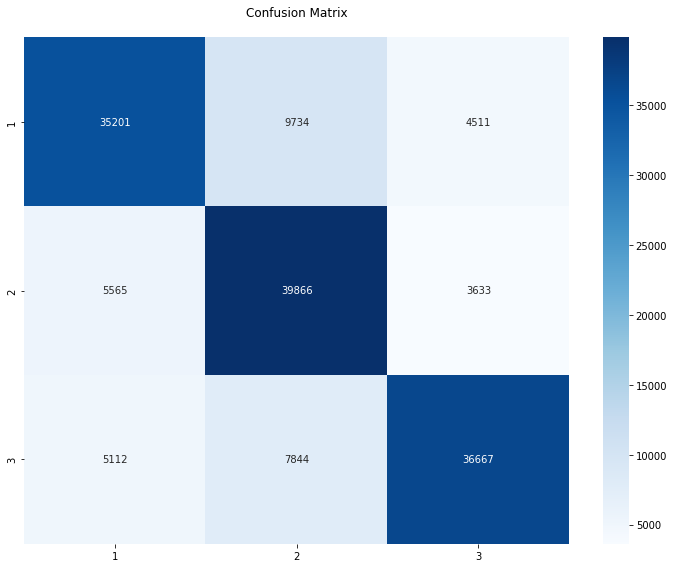

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(y_test, lgb_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['1', '2', '3'],
                                 index=['1', '2', '3'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix\n")
plt.tight_layout()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, lgb_pred))

              precision    recall  f1-score   support

           1       0.77      0.71      0.74     49446
           2       0.69      0.81      0.75     49064
           3       0.82      0.74      0.78     49623

    accuracy                           0.75    148133
   macro avg       0.76      0.75      0.75    148133
weighted avg       0.76      0.75      0.75    148133



----

In [ ]:
predict_train = lgb.predict(x_train)
print("train score : {}".format(lgb.score(x_train, y_train)))
predict_test = lgb.predict(x_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, lgb.predict(x_test)))
print("test score : {}".format(lgb.score(x_test, y_test)))

---

In [ ]:
def get_clf_eval(y_test, lgb_pred):
    confusion = confusion_matrix(y_test, lgb_pred)
    accuracy = accuracy_score(y_test, lgb_pred)
    precision = precision_score(y_test, lgb_pred, average = 'macro')
    recall = recall_score(y_test, lgb_pred, average = 'macro')
    F1 = f1_score(y_test, lgb_pred, average = 'macro')
    # AUC = roc_auc_score(y_test, lgb_pred, multi_class='ovo')
    print('오차행렬:\n', confusion)
    print('\n정확도:{:.4f}'.format(accuracy))
    print('정밀도:{:.4f}'.format(precision))
    print('재현율:{:.4f}'.format(recall))
    print('F1:{:.4f}'.format(F1))
    # print('AUC:{:.4f}'.format(AUC))

In [ ]:
get_clf_eval(y_test, lgb_pred)

---

In [ ]:
# plot_importance()를 이용한 피처 중요도 시각화

from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6))
plot_importance(lgb, max_num_features=6, ax=ax) # 상위 6개만

### 에러 측정

In [ ]:
# mse = mean_squared_error(y_test, predict_test)
# r2 = r2_score(y_test, predict_test)

In [ ]:
# print('Mean squared error: ', mse)
# print('R2 score: ', r2)

In [ ]:
# final_result = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(predict_test)], axis = 1)

In [ ]:
# final_result.columns = ['label','predict']

In [ ]:
# sns.regplot(x = 'label', y = 'predict', data = final_result)

----

### LGBMClassifier 상위 모델(?) -> HistGradientBoostingClassifier

In [ ]:
# lgb_clf = lgb.LGBMClassifier(num_leaves=31, objective='binary')
# lgb_clf.fit(x_train, y_train)
# y_pred = lgb_clf.predict(x_test)
# accuracy_score(y_test, y_pred)

# d_train = lgb.Dataset(x_train, label=y_train)
# param = {'num_iterations': 100, 'learning_rate' : 0.1, 'max_depth' : -1, 'objective': 'binary', 'metric':'auc'}

In [ ]:
# from sklearn.ensemble import HistGradientBoostingClassifier as hgbc

In [ ]:
# hgbc.score(x_train)